In [1]:
from simtk import unit
from openmm import app

from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
from utils import *

import os

class BaseSimulator():
    """
    .. warning :: The base class should not be used directly

    Parameters
    ------------
    temperature : simtk.unit
        default 298.15 K
    pressure : simtk.unit
        default 1.013 bar
    time_step : simtk.unit
        default 2 fs


    .. todo::
        - setter and getter for phy constants
    """

    temperature = 298.15 * unit.kelvin
    pressure = 1.013 * unit.bar
    time_step = 0.002 * unit.picoseconds
    equil_steps = 50000  #100 ps

    @classmethod
    def via_openmm(cls, parmed_obj, file_name, file_path = "./", platform = "CUDA", num_steps = 5000 * 500, write_out_freq = 5000, report_equilibration = True, report_production = False,
    constrain_all_bonds = True, **kwargs):
        """
        Runs simulation using OpenMM.

        Parameters
        ------------
        parmed_obj : parmed.structure
            Parmed object of the fully parameterised simulated system.
        file_name : str
            No file type postfix is necessary
        file_path : str
            Default to current directory
        platform : str
            The computing architecture to do the calculation, default to CUDA, CPU, OpenCL is also possible.
        num_steps : int
            Number of production simulation to run, default 2,500,000 steps, i.e. 5 ns.
        write_out_freq : int
            Write out every nth frame of simulated trajectory, default to every 5000 frame write out one, i.e. 10 ps per frame.

        Returns
        --------
        path : str
            The absolute path where the trajectory is written to.
        """
        platform = Platform.getPlatformByName(platform)
        pmd = parmed_obj
        path = '{}/{}.h5'.format(file_path, file_name)

        constrain_what_bond = app.AllBonds if constrain_all_bonds else app.HBonds
        system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)


        thermostat = AndersenThermostat(cls.temperature, 1/unit.picosecond)
        system.addForce(thermostat)
        barostat = MonteCarloBarostat(cls.pressure , cls.temperature)
        system.addForce(barostat)
        integrator = VerletIntegrator(cls.time_step)

        simulation = Simulation(pmd.topology, system, integrator, platform)
        simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
        simulation.context.setPositions(pmd.positions)
        simulation.minimizeEnergy()

        #Eq
        try:
            cls.equil_steps = kwargs["equil_steps"]
        except KeyError:
            pass
        if report_equilibration:
            #print(cls.equil_steps, " steps")
            simulation.reporters.append(StateDataReporter("{}/equilibration_{}.dat".format(file_path, file_name), cls.equil_steps//5000, step=True, volume = True, temperature = True,density=True))
        simulation.step(cls.equil_steps)

        state = simulation.context.getState(getPositions = True, getVelocities = True)
        pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(),state.getVelocities(), state.getPeriodicBoxVectors()

        #Production
        del system
        del simulation

        system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)

        thermostat = AndersenThermostat(cls.temperature, 1/unit.picosecond)
        system.addForce(thermostat)

        integrator = VerletIntegrator(cls.time_step)
        simulation = Simulation(pmd.topology, system, integrator, platform)
        simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
        simulation.context.setPositions(pmd.positions)
        if report_production:
            simulation.reporters.append(StateDataReporter("{}/production_{}.dat".format(file_path, file_name), num_steps//50000, step=True, potentialEnergy = True, temperature = True))
        simulation.reporters.append(HDF5Reporter(path, write_out_freq))
        simulation.step(num_steps)

        return os.path.abspath(path)


class SolutionSimulator(BaseSimulator):
    """
    Perform solution simulation, namely one copy of solute in water box. Currently identical to BaseSimulator

    Parameters
    -----------
    equil_steps : int
        number of steps during equilibraion, default 50,000 steps, i.e. 100 ps
    """
    equil_steps = 50000  #100 ps

class LiquidSimulator(BaseSimulator):
    """
    Perform liquid simulation, namely multiple copy of the same molecule.

    Parameters
    -----------
    equil_steps : int
        number of steps during equilibraion, default 500,000 steps, i.e. 1 ns
    """
    equil_steps = 500000  #1 ns

In [2]:
# Load the PDB file and XML system into ParmEd
import openmm
from openmm.app.pdbfile import PDBFile
import parmed
import Parameteriser
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from simtk import unit
smiles = "c1ccccc1"
print('Molobject created, parameterising...')
rdk_pmd = Parameteriser.LiquidParameteriser.via_rdkit(smiles=smiles,density=0.62 * unit.gram/unit.milliliter)
# SolutionSimulator.via_openmm(rdk_pmd, file_name = 'test_benzene_baseline', file_path = './',
#                              platform = "CUDA", num_steps = 50 * 500)

Molobject created, parameterising...


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/parmed/structure.py:1775: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

##############################################################
The code at packmol.py:275 requires the openeye.oechem package
##############################################################



# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmpy35ye1v6/tmpwjsgcd7v.pdb
add_amber_ter


structure /tmp/tmpy35ye1v6/tmp1djhsvy8.pdb
  number 100
  inside box 0. 0. 0. 41.332025 41.332025 41.332025
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.010 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /tmp/tmpy35ye1v6/tmpwjsgcd7v.pdb
  Reading coordinate file: /tmp/tmpy35ye1v6/tmp1djhsvy8.pdb
  Number of independent structures:            1
  The s

In [3]:
SolutionSimulator.via_openmm(rdk_pmd, file_name = 'test_benzene_baseline', file_path = './',
                             platform = "CUDA", num_steps = 50 * 500)

'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/test_benzene_baseline.h5'

In [18]:
#example with low experimental density (pentane, 0.61 g/mL)
smiles = 'CCCCC'
rdk_pmd = Parameteriser.LiquidParameteriser.via_rdkit(smiles=smiles,density=0.62 * unit.gram/unit.milliliter)
SolutionSimulator.via_openmm(rdk_pmd, file_name = 'test_pentane_baseline_d062', file_path = './',
                             platform = "CUDA", num_steps = 50 * 500)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/parmed/structure.py:1775: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

##############################################################
The code at packmol.py:275 requires the openeye.oechem package
##############################################################



# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmp139sce03/tmpwnb7cbaw.pdb
add_amber_ter


structure /tmp/tmp139sce03/tmpsvi2scfy.pdb
  number 100
  inside box 0. 0. 0. 40.252344 40.252344 40.252344
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.010 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /tmp/tmp139sce03/tmpwnb7cbaw.pdb
  Reading coordinate file: /tmp/tmp139sce03/tmpsvi2scfy.pdb
  Number of independent structures:            1
  The s

'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/test_pentane_baseline_d062.h5'

In [17]:
#example with low experimental density (pentane, 0.61 g/mL)
smiles = 'CCCCC'
rdk_pmd = Parameteriser.LiquidParameteriser.via_rdkit(smiles=smiles,density=0.95 * unit.gram/unit.milliliter)
SolutionSimulator.via_openmm(rdk_pmd, file_name = 'test_pentane_baseline_d095', file_path = './',
                             platform = "CUDA", num_steps = 50 * 500)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/parmed/structure.py:1775: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

##############################################################
The code at packmol.py:275 requires the openeye.oechem package
##############################################################



# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmp7hbk0tzn/tmpkvfw_mp3.pdb
add_amber_ter


structure /tmp/tmp7hbk0tzn/tmp29oeu8aa.pdb
  number 100
  inside box 0. 0. 0. 34.915147 34.915147 34.915147
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.010 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /tmp/tmp7hbk0tzn/tmpkvfw_mp3.pdb
  Reading coordinate file: /tmp/tmp7hbk0tzn/tmp29oeu8aa.pdb
  Number of independent structures:            1
  The s

'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/test_pentane_baseline_d095.h5'

In [6]:
#example with high experimental density 
smiles = 'C(C(Br)Br)(Br)Br'
rdk_pmd = Parameteriser.LiquidParameteriser.via_rdkit(smiles=smiles,density=0.62 * unit.gram/unit.milliliter)
SolutionSimulator.via_openmm(rdk_pmd, file_name = 'test_1122tetrabromoethane_baseline_d062', file_path = './',
                             platform = "CUDA", num_steps = 50 * 500)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/parmed/structure.py:1775: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

##############################################################
The code at packmol.py:275 requires the openeye.oechem package
##############################################################



# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmpav9iywo3/tmp9ihqmz7q.pdb
add_amber_ter


structure /tmp/tmpav9iywo3/tmp6lvyps3x.pdb
  number 100
  inside box 0. 0. 0. 67.856417 67.856417 67.856417
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.010 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /tmp/tmpav9iywo3/tmp9ihqmz7q.pdb
  Reading coordinate file: /tmp/tmpav9iywo3/tmp6lvyps3x.pdb
  Number of independent structures:            1
  The s

KeyboardInterrupt: 

In [7]:
#example with high experimental density 
smiles = 'C(C(Br)Br)(Br)Br'
rdk_pmd = Parameteriser.LiquidParameteriser.via_rdkit(smiles=smiles,density=0.95 * unit.gram/unit.milliliter)
SolutionSimulator.via_openmm(rdk_pmd, file_name = 'test_1122tetrabromoethane_baseline_d095', file_path = './',
                             platform = "CUDA", num_steps = 50 * 500)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/parmed/structure.py:1775: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

##############################################################
The code at packmol.py:275 requires the openeye.oechem package
##############################################################



# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmp0btqz3fh/tmpnk2wotmd.pdb
add_amber_ter


structure /tmp/tmp0btqz3fh/tmp64krhme6.pdb
  number 100
  inside box 0. 0. 0. 58.859100 58.859100 58.859100
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.010 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /tmp/tmp0btqz3fh/tmpnk2wotmd.pdb
  Reading coordinate file: /tmp/tmp0btqz3fh/tmp64krhme6.pdb
  Number of independent structures:            1
  The s

'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/test_1122tetrabromoethane_baseline_d095.h5'

In [ ]:
# #example with huge molecule
# mol = Chem.AddHs(Chem.MolFromSmiles('CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'))
# rdDistGeom.EmbedMolecule(mol)
# print('Molobject created, parameterising...')
# rdk_pmd = Parameteriser.SolutionParameteriser.via_rdkit(mol = mol)
# SolutionSimulator.via_openmm(rdk_pmd, file_name = 'test_long_mol_baseline', file_path = './',
#                              platform = "CUDA", num_steps = 50 * 500)

Molobject created, parameterising...


KeyboardInterrupt: 

In [8]:
#example with chloroform
smiles = 'ClC(Cl)Cl'
rdk_pmd = Parameteriser.LiquidParameteriser.via_rdkit(smiles=smiles,density=0.62 * unit.gram/unit.milliliter)
SolutionSimulator.via_openmm(rdk_pmd, file_name = 'test_chloroform_baseline_d062', file_path = './',
                             platform = "CUDA", num_steps = 50 * 500)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/parmed/structure.py:1775: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

##############################################################
The code at packmol.py:275 requires the openeye.oechem package
##############################################################



# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmpx90wc_3i/tmpkdvmwyq_.pdb
add_amber_ter


structure /tmp/tmpx90wc_3i/tmpayawsw25.pdb
  number 100
  inside box 0. 0. 0. 47.608573 47.608573 47.608573
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.010 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /tmp/tmpx90wc_3i/tmpkdvmwyq_.pdb
  Reading coordinate file: /tmp/tmpx90wc_3i/tmpayawsw25.pdb
  Number of independent structures:            1
  The s

'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/test_chloroform_baseline_d062.h5'

In [71]:
smiles = 'ClC(Cl)Cl'
rdk_pmd = Parameteriser.LiquidParameteriser.via_rdkit(smiles=smiles,density=0.62 * unit.gram/unit.milliliter)
#save as pdb
rdk_pmd.save('chloroform_top.pdb')


# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmpsnvzbg9v/tmp32t1ksry.pdb
add_amber_ter


structure /tmp/tmpsnvzbg9v/tmpq6jhamyp.pdb
  number 100
  inside box 0. 0. 0. 47.608573 47.608573 47.608573
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.010 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /tmp/tmpsnvzbg9v/tmp32t1ksry.pdb
  Reading coordinate file: /tmp/tmpsnvzbg9v/tmpq6jhamyp.pdb
  Number of independent structures:            1
  The s

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/parmed/structure.py:1775: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

##############################################################
The code at packmol.py:275 requires the openeye.oechem package
##############################################################


In [19]:
#example with chloroform
smiles = 'ClC(Cl)Cl'
rdk_pmd = Parameteriser.LiquidParameteriser.via_rdkit(smiles=smiles,density=0.95 * unit.gram/unit.milliliter)
SolutionSimulator.via_openmm(rdk_pmd, file_name = 'test_chloroform_baseline_d095', file_path = './',
                             platform = "CUDA", num_steps = 50 * 500)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/parmed/structure.py:1775: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

##############################################################
The code at packmol.py:275 requires the openeye.oechem package
##############################################################



# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmp0agcpb__/tmpvhcij_nw.pdb
add_amber_ter


structure /tmp/tmp0agcpb__/tmpz59t_lnh.pdb
  number 100
  inside box 0. 0. 0. 41.295988 41.295988 41.295988
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.010 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /tmp/tmp0agcpb__/tmpvhcij_nw.pdb
  Reading coordinate file: /tmp/tmp0agcpb__/tmpz59t_lnh.pdb
  Number of independent structures:            1
  The s

'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/test_chloroform_baseline_d095.h5'

In [43]:
#example with benzene
smiles = 'c1ccccc1'
rdk_pmd = Parameteriser.LiquidParameteriser.via_rdkit(smiles=smiles,density=0.95 * unit.gram/unit.milliliter)
SolutionSimulator.via_openmm(rdk_pmd, file_name = 'test_benzene_baseline_d095', file_path = './',
                             platform = "CUDA", num_steps = 1 * 1)
rdk_pmd = Parameteriser.LiquidParameteriser.via_rdkit(smiles=smiles,density=0.62 * unit.gram/unit.milliliter)
SolutionSimulator.via_openmm(rdk_pmd, file_name = 'test_benzene_baseline_d062', file_path = './',
                             platform = "CUDA", num_steps = 1 * 1)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/parmed/structure.py:1775: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

##############################################################
The code at packmol.py:275 requires the openeye.oechem package
##############################################################



# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmpno3h3pv0/tmpevt7pq8j.pdb
add_amber_ter


structure /tmp/tmpno3h3pv0/tmpfqb1us_r.pdb
  number 100
  inside box 0. 0. 0. 35.851669 35.851669 35.851669
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.010 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /tmp/tmpno3h3pv0/tmpevt7pq8j.pdb
  Reading coordinate file: /tmp/tmpno3h3pv0/tmpfqb1us_r.pdb
  Number of independent structures:            1
  The s

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/parmed/structure.py:1775: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

##############################################################
The code at packmol.py:275 requires the openeye.oechem package
##############################################################



# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmpmza7lbb_/tmpx5ylbbps.pdb
add_amber_ter


structure /tmp/tmpmza7lbb_/tmpz_yy23oa.pdb
  number 100
  inside box 0. 0. 0. 41.332025 41.332025 41.332025
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.010 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /tmp/tmpmza7lbb_/tmpx5ylbbps.pdb
  Reading coordinate file: /tmp/tmpmza7lbb_/tmpz_yy23oa.pdb
  Number of independent structures:            1
  The s

'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/test_benzene_baseline_d062.h5'

In [70]:
#example with benzene
smiles = 'c1ccccc1'
rdk_pmd = Parameteriser.LiquidParameteriser.via_rdkit(smiles=smiles,density=0.62 * unit.gram/unit.milliliter)
#save topology as pdb
rdk_pmd.save('benzene_top.pdb')


# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmpf6w0ih2y/tmph9kc1zio.pdb
add_amber_ter


structure /tmp/tmpf6w0ih2y/tmpz9klz_m0.pdb
  number 100
  inside box 0. 0. 0. 41.332025 41.332025 41.332025
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.010 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /tmp/tmpf6w0ih2y/tmph9kc1zio.pdb
  Reading coordinate file: /tmp/tmpf6w0ih2y/tmpz9klz_m0.pdb
  Number of independent structures:            1
  The s

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/parmed/structure.py:1775: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

##############################################################
The code at packmol.py:275 requires the openeye.oechem package
##############################################################


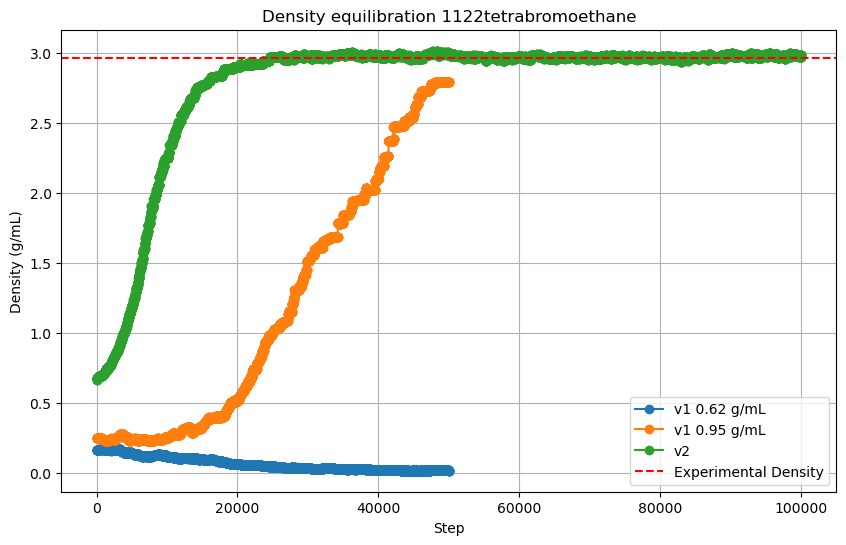

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_multiple_steps_vs_density(file_paths, labels,experimental_density = None,name=None):
    plt.figure(figsize=(10, 6))
    
    # Iterate through each file path and corresponding label
    for file_path, label in zip(file_paths, labels):
        # Read the .dat file into a DataFrame
        try:
            df = pd.read_csv(file_path)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            continue
        
        # Plot Step against Density with a unique color and label
        plt.plot(df['#"Step"'], df['Density (g/mL)'], marker='o', linestyle='-', label=label,s=4
    
    # Add labels, title, grid, and legend
    if experimental_density:
        plt.axhline(y=experimental_density, color='r', linestyle='--', label='Experimental Density')
    plt.xlabel('Step')
    plt.ylabel('Density (g/mL)')
    if name:
        plt.title(f'Density equilibration {name}')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage with a list of file paths and corresponding labels
path_prefix = '/localhome/cschiebroek/MDFP_VP/mdfptools/carl/equilibration_test_'
name = "1122tetrabromoethane"
file_paths = [f'{path_prefix}{name}_baseline_d062.dat', f'{path_prefix}{name}_baseline_d095.dat', f'{path_prefix}{name}_full_equil.dat_0']
labels = ['v1 0.62 g/mL', 'v1 0.95 g/mL', 'v2']
plot_multiple_steps_vs_density(file_paths, labels, 2.9632,name=name)


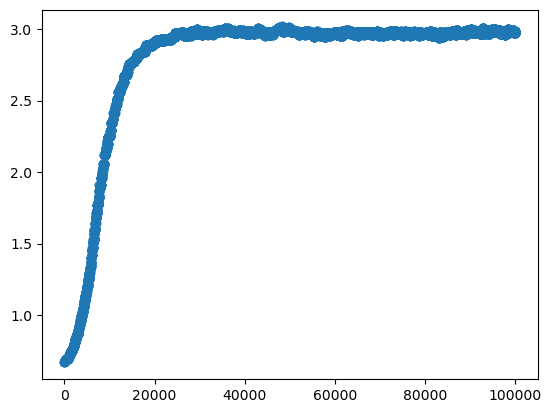

In [31]:
path_prefix = '/localhome/cschiebroek/MDFP_VP/mdfptools/carl/equilibration_test_'
name = "1122tetrabromoethane"
file_path = f'{path_prefix}{name}_full_equil.dat_0'
df = pd.read_csv(file_path)
plt.plot(df['#"Step"'], df['Density (g/mL)'], marker='o', linestyle='-', label=name)
#get color of this line
color = plt.gca().lines[-1].get_color()
file_path = f'{path_prefix}{name}_full_equil.dat_1'
df = pd.read_csv(file_path)
plt.plot(df['#"Step"'], df['Density (g/mL)'], marker='o', linestyle='-', label=name, color=color)


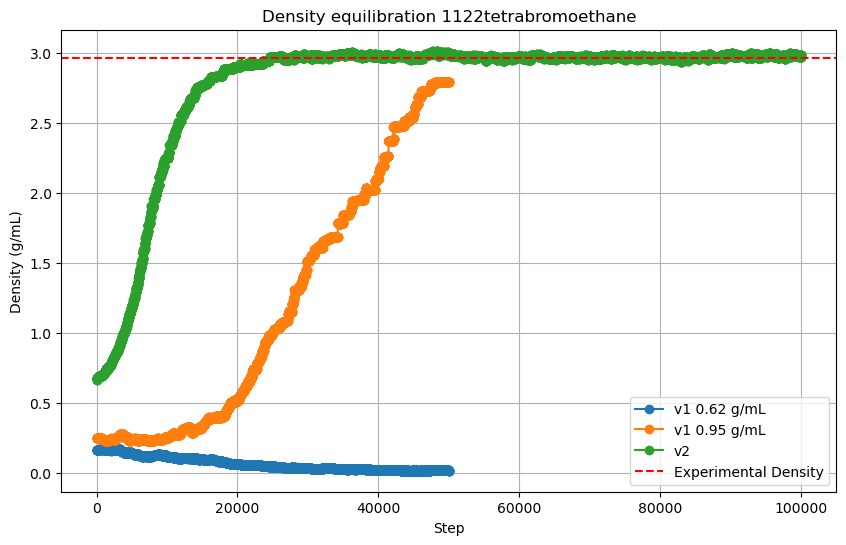

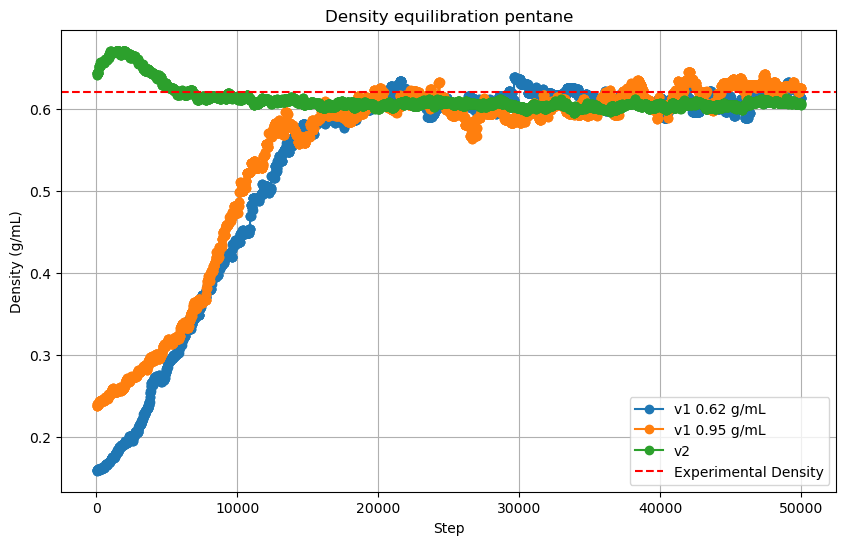

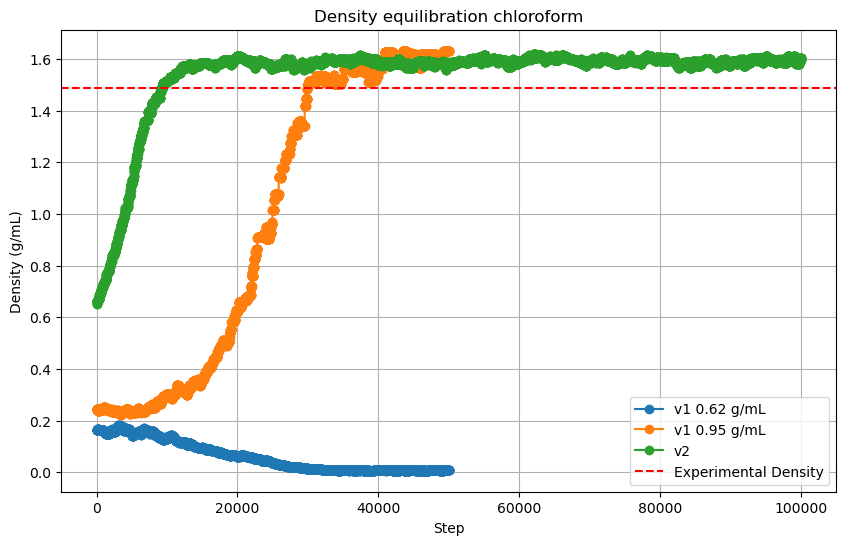

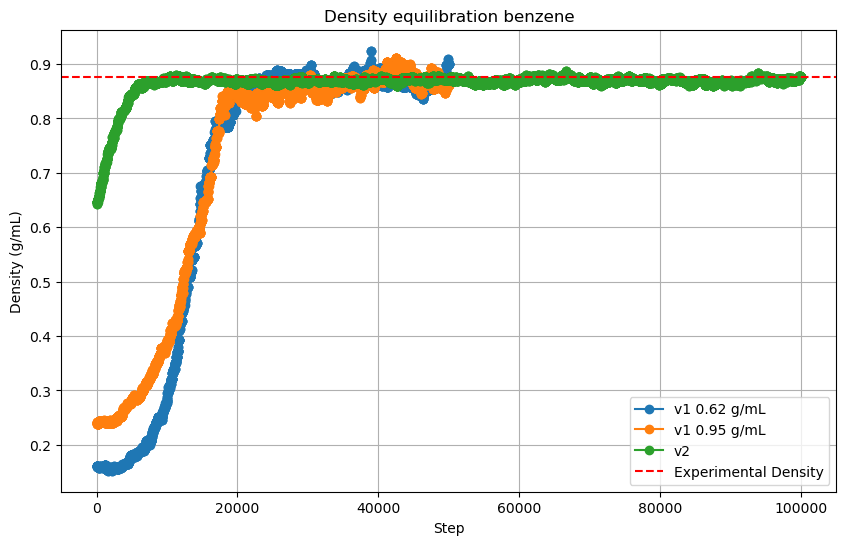

In [45]:
for name,densities in zip(['1122tetrabromoethane','pentane','chloroform','benzene'],[2.9632,0.62,1.49,0.876]):
    file_paths = [f'{path_prefix}{name}_baseline_d062.dat', f'{path_prefix}{name}_baseline_d095.dat', f'{path_prefix}{name}_full_equil.dat_0']
    labels = ['v1 0.62 g/mL', 'v1 0.95 g/mL', 'v2']
    plot_multiple_steps_vs_density(file_paths, labels, name=name,experimental_density=densities)

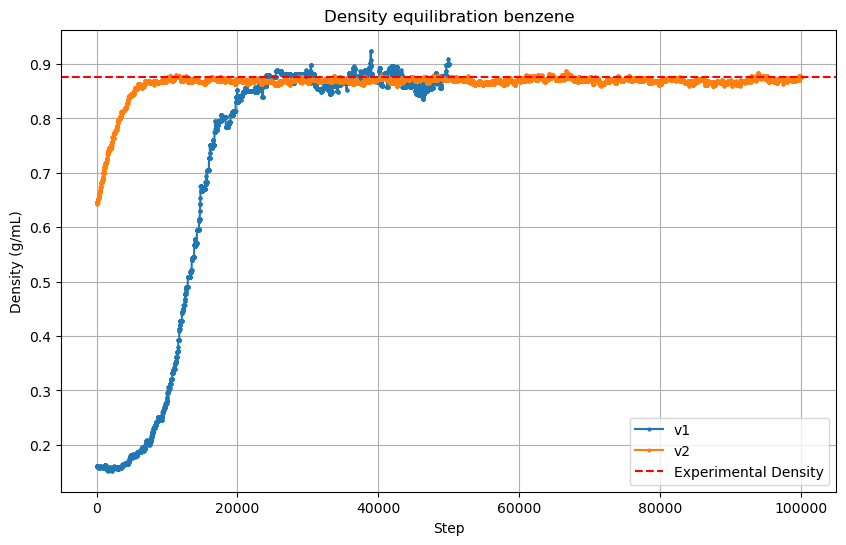

In [72]:
name = 'benzene'
densities = 0.876
file_paths = [f'{path_prefix}{name}_baseline_d062.dat', f'{path_prefix}{name}_full_equil.dat_0']
labels = ['v1','v2']
plot_multiple_steps_vs_density(file_paths, labels, name=name,experimental_density=densities)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/parmed/structure.py:1775: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)

##############################################################
The code at packmol.py:275 requires the openeye.oechem package
##############################################################



# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmp3_gm6gz9/tmp_2v227cf.pdb
add_amber_ter


structure /tmp/tmp3_gm6gz9/tmp4vad_ti_.pdb
  number 1000
  inside box 0. 0. 0. 89.047149 89.047149 89.047149
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.010 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /tmp/tmp3_gm6gz9/tmp_2v227cf.pdb
  Reading coordinate file: /tmp/tmp3_gm6gz9/tmp4vad_ti_.pdb
  Number of independent structures:            1
  The 

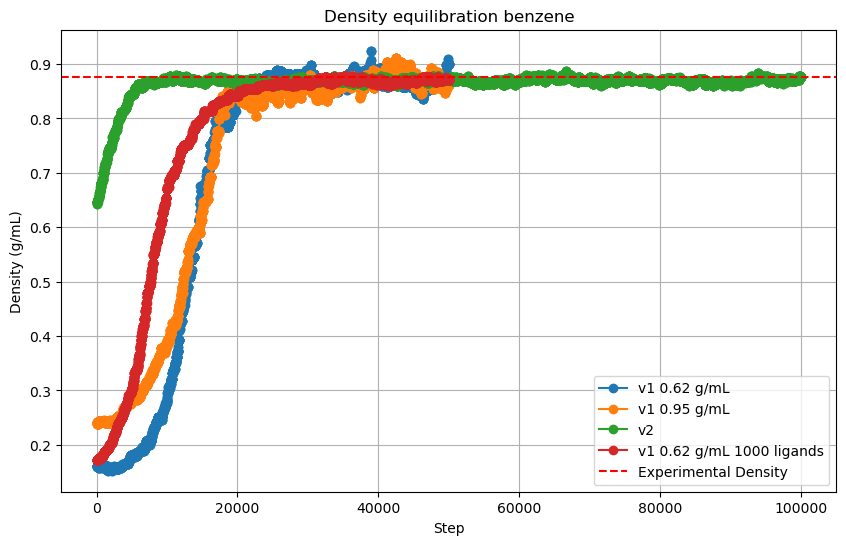

In [47]:
smiles = 'c1ccccc1'
rdk_pmd = Parameteriser.LiquidParameteriser.via_rdkit(smiles=smiles,density=0.62 * unit.gram/unit.milliliter,num_lig=1000)
SolutionSimulator.via_openmm(rdk_pmd, file_name = 'test_benzene_baseline_d062_1000', file_path = './',
                             platform = "CUDA", num_steps = 1 * 1)
name = "benzene"
file_paths = [f'{path_prefix}{name}_baseline_d062.dat', f'{path_prefix}{name}_baseline_d095.dat', f'{path_prefix}{name}_full_equil.dat_0',f'{path_prefix}{name}_baseline_d062_1000.dat']
labels = ['v1 0.62 g/mL', 'v1 0.95 g/mL', 'v2','v1 0.62 g/mL 1000 ligands']
plot_multiple_steps_vs_density(file_paths, labels,0.876,name=name)

In [56]:
def plot_multiple_steps_vs_density(file_paths, labels,experimental_density = None,name=None):
    plt.figure(figsize=(10, 6))
    
    # Iterate through each file path and corresponding label
    for file_path, label in zip(file_paths, labels):
        # Read the .dat file into a DataFrame
        try:
            df = pd.read_csv(file_path)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            continue
        
        # Plot Step against Density with a unique color and label
        plt.plot(df['#"Step"'], df['Density (g/mL)'], marker='o', linestyle='-', label=label,markersize=2)
    
    # Add labels, title, grid, and legend
    if experimental_density:
        plt.axhline(y=experimental_density, color='r', linestyle='--', label='Experimental Density')
    plt.xlabel('Step')
    plt.ylabel('Density (g/mL)')
    if name:
        plt.title(f'Density equilibration {name}')
    plt.grid(True)
    plt.legend()
    plt.show()

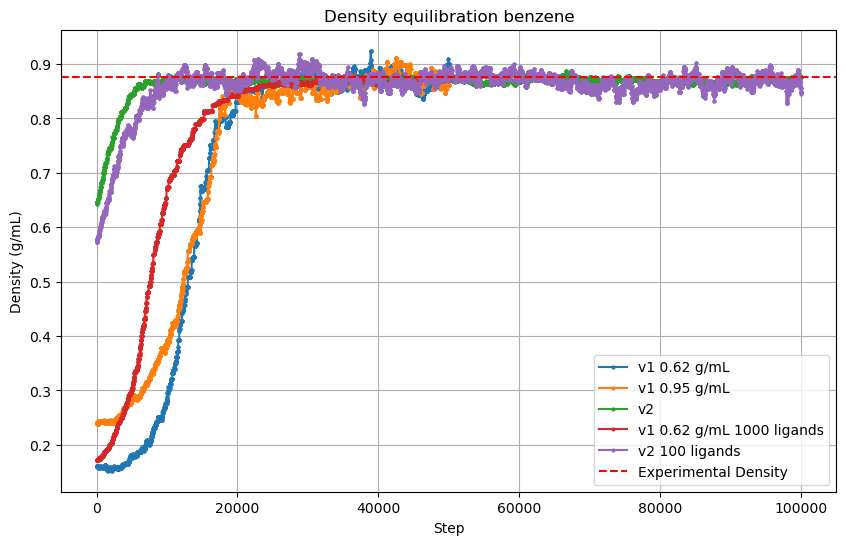

In [57]:
file_paths = [f'{path_prefix}{name}_baseline_d062.dat', f'{path_prefix}{name}_baseline_d095.dat', f'{path_prefix}{name}_full_equil.dat_0',f'{path_prefix}{name}_baseline_d062_1000.dat',f'{path_prefix}{name}_full_equil_n100.dat_0']
labels = ['v1 0.62 g/mL', 'v1 0.95 g/mL', 'v2','v1 0.62 g/mL 1000 ligands','v2 100 ligands']
plot_multiple_steps_vs_density(file_paths, labels,0.876,name=name)

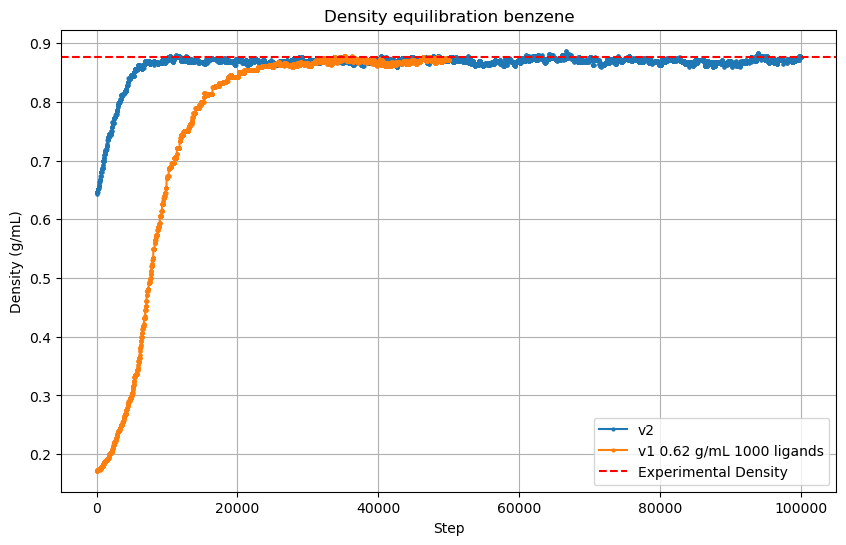

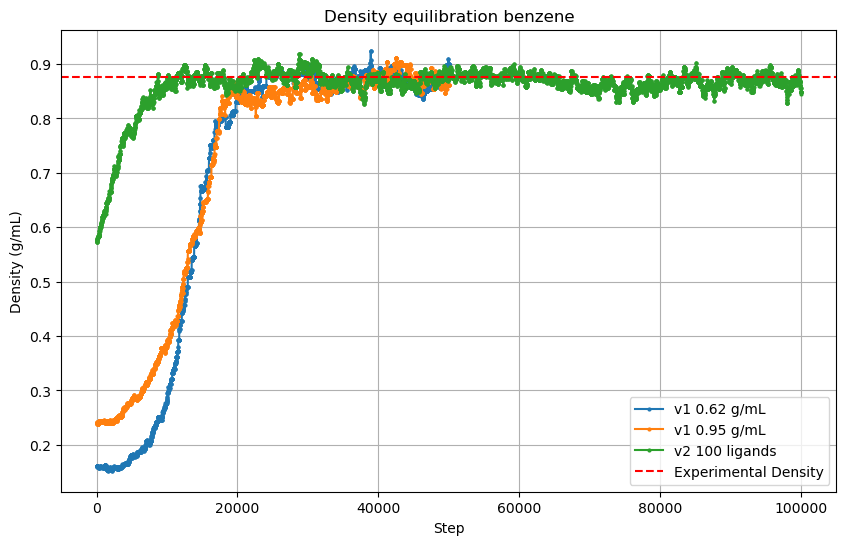

In [58]:
#now seperately the 100 ligands and 1000 ligands
file_paths_1000 = [f'{path_prefix}{name}_full_equil.dat_0',f'{path_prefix}{name}_baseline_d062_1000.dat']
labels_1000 = ['v2','v1 0.62 g/mL 1000 ligands']
plot_multiple_steps_vs_density(file_paths_1000, labels_1000,0.876,name=name)
file_path_100 = [f for f in file_paths if f not in file_paths_1000]
labels_100 = [f for f in labels if f not in labels_1000]
plot_multiple_steps_vs_density(file_path_100, labels_100,0.876,name=name)


In [73]:
file_path_100

['/localhome/cschiebroek/MDFP_VP/mdfptools/carl/equilibration_test_benzene_baseline_d062.dat',
 '/localhome/cschiebroek/MDFP_VP/mdfptools/carl/equilibration_test_benzene_baseline_d095.dat',
 '/localhome/cschiebroek/MDFP_VP/mdfptools/carl/equilibration_test_benzene_full_equil_n100.dat_0']

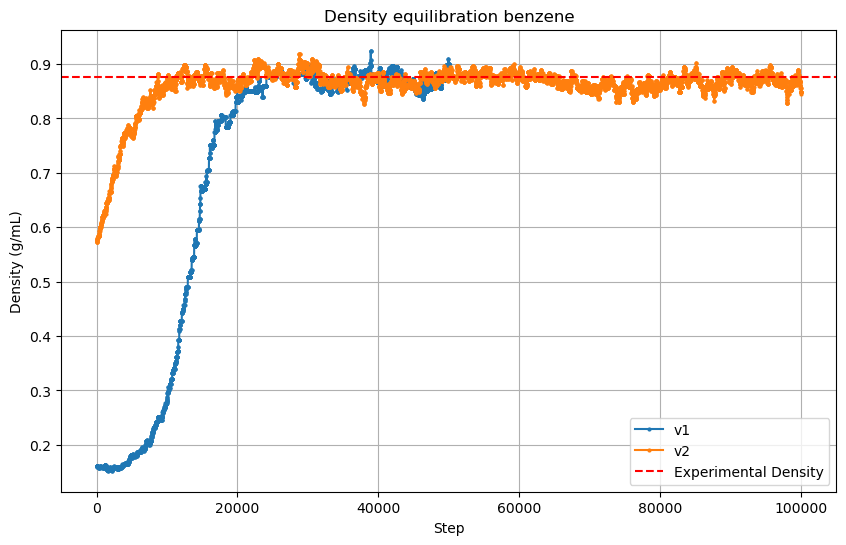

In [76]:
file_paths_fig1 = [file_path_100[0],file_path_100[-1]]
labels_fig1 = ['v1','v2']
plot_multiple_steps_vs_density(file_paths_fig1, labels_fig1,0.876,name=name)

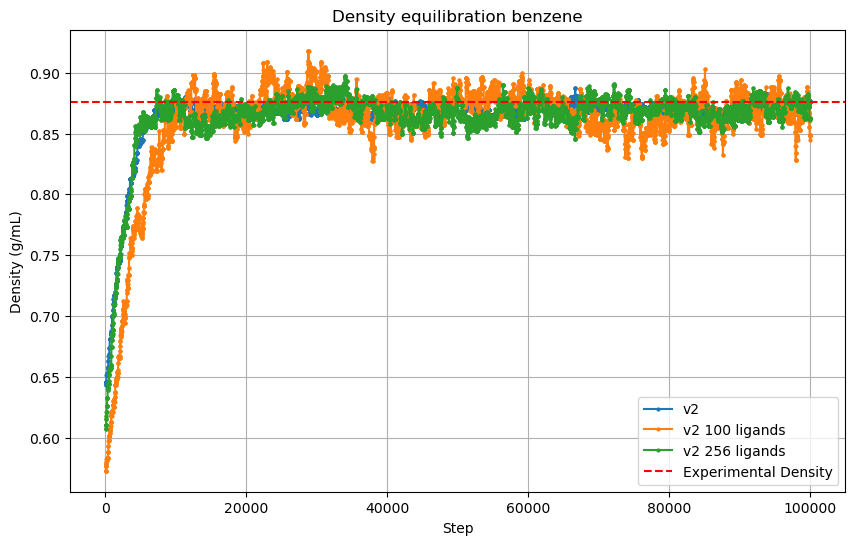

In [78]:
#now v2 1000 vs 100 vs 256
file_paths = [f'{path_prefix}{name}_full_equil.dat_0',f'{path_prefix}{name}_full_equil_n100.dat_0',f'{path_prefix}{name}_full_equil_n256.dat_0']
labels = ['v2','v2 100 ligands','v2 256 ligands']
plot_multiple_steps_vs_density(file_paths, labels,0.876,name=name)

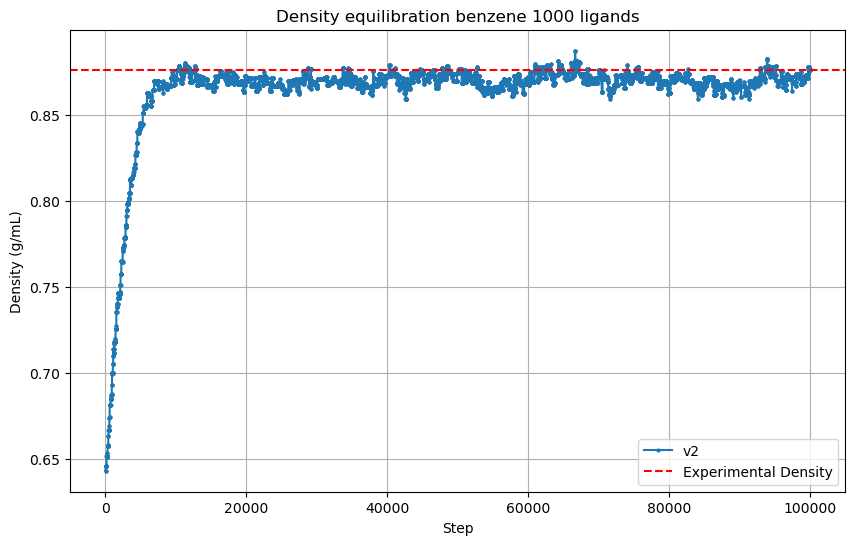

In [79]:
plot_multiple_steps_vs_density(file_paths[0:1], labels[0:1],0.876,name=name + ' 1000 ligands')

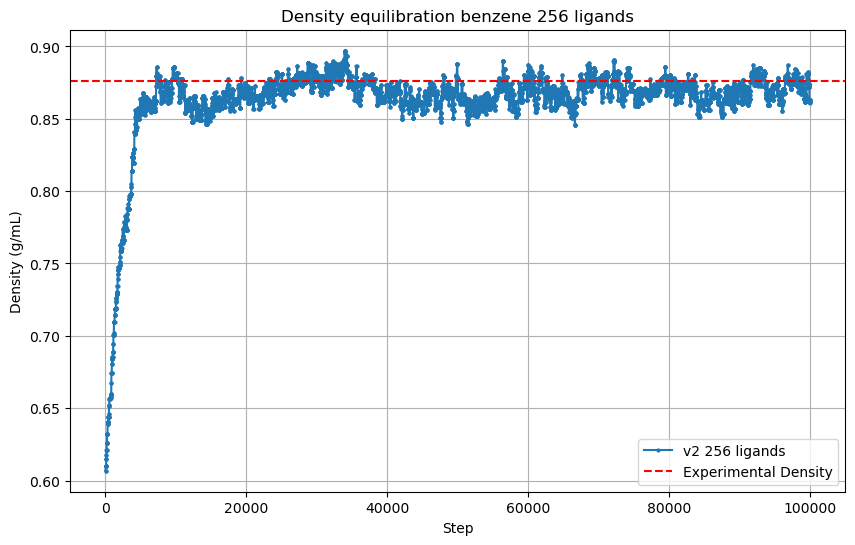

In [80]:
plot_multiple_steps_vs_density(file_paths[2:], labels[2:],0.876,name=name + ' 256 ligands')

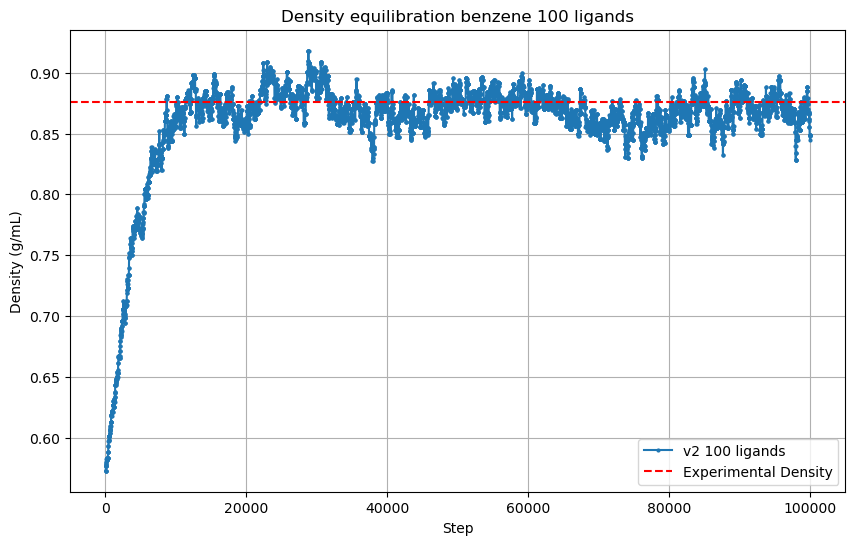

In [81]:
plot_multiple_steps_vs_density(file_paths[1:2], labels[1:2],0.876,name=name + ' 100 ligands')

In [69]:
smiles = 'c1ccccc1'
rdk_pmd_water = Parameteriser.SolutionParameteriser.via_rdkit(smiles=smiles)
rdk_pmd_water
#save as pdb


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/parmed/structure.py:1775: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)


FileNotFoundError: /data/tip3p.prmtop does not exist

In [ ]:
smiles = 'c1ccccc1'
rdk_pmd = Parameteriser.LiquidParameteriser.via_rdkit(smiles=smiles,density=0.62 * unit.gram/unit.milliliter,num_lig=1000)
SolutionSimulator.via_openmm(rdk_pmd, file_name = 'test_benzene_baseline_d062_1000', file_path = './',
                             platform = "CUDA", num_steps = 1 * 1)
name = "benzene"
file_paths = [f'{path_prefix}{name}_baseline_d062.dat', f'{path_prefix}{name}_baseline_d095.dat', f'{path_prefix}{name}_full_equil.dat_0',f'{path_prefix}{name}_baseline_d062_1000.dat']
labels = ['v1 0.62 g/mL', 'v1 0.95 g/mL', 'v2','v1 0.62 g/mL 1000 ligands']
plot_multiple_steps_vs_density(file_paths, labels,0.876,name=name)